# 2.5.2: The Coffee Cooling Problems

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [1]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')
download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/chap04.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap04 import *
import pandas as pd
import numpy as np


Downloaded ModSimPy_Functions/modsim.py
Downloaded ModSimPy_Functions/chap04.py


In the previous notebook we wrote a simulation of a cooling cup of
coffee. 
Given the initial temperature, the temperature of the atmosphere, and the material characteristics of milk and coffee, we predicted the temperature of the both liquids over time, and then used a root finding algorithm to estimate `r` so that the data would validate our model.

<br>

Now let's put it together.  The milk and the coffee, that is.
In this notebook we'll write a function that simulates mixing the two liquids, and use it to answer the question we started with: is it better to mix the coffee and milk at the beginning, the end, or somewhere in the middle?

## Iteration: Adding Mixing to the Mix

To solve the problem, we need tools to do three steps:

* Find the change in temperature of the individual components for a given amount of time
* Find the change in temperature that results from mixing the two liquids
* Find the change in temperature of the mixed liquids for the remaining time

If we plan well, we should be able to use the same functions to do step 1 and 3: we just have to be careful to define the masses, specific heats and $r$ value for the liquids.   But we'll need a new function to model the mixing process.

### The physics of mixing liquids

When we mix two liquids, the temperature of the mixture depends on the
temperatures of the ingredients as well as their volumes, densities, and specific heat capacities.  Assuming there are no chemical reactions that either produce or consume heat, the total thermal energy of the system is the same before and after mixing; in other words, thermal energy is *conserved*.

<br>

If the temperature of the first liquid is $T_1$, the temperature of the second liquid is $T_2$, and the final temperature of the mixture is $T$, the heat transfer into the first liquid is $C_1 (T - T_1)$ and the heat transfer into the second liquid is $C_2 (T - T_2)$, where $C_1$ and $C_2$ are the thermal masses $m~c_p$ of the liquids.

<br>

In order to keep the total energy the same, the heat lost by the coffee must equal the heat gained by the milk.  In other words, these heat transfers must add up to 0:

<br>

$$C_1 (T - T_1) + C_2 (T - T_2) = 0$$ 

<br>

We can solve this equation for T:

<br>

$$T = \frac{C_1 T_1 + C_2 T_2}{C_1 + C_2}$$ 

<br>

For the coffee cooling problem, we have the volume of each liquid; if we also know the density, $\rho$, and the specific heat capacity, $c_p$, we can compute thermal mass: 

<br>

$$C = \rho V c_p$$ 

<br>

If the liquids have the same density and heat capacity, they drop out of the equation, and we can write:

<br>

$$T = \frac{V_1 T_1 + V_2 T_2}{V_1 + V_2}$$ 

<br>

where $V_1$ and $V_2$ are the volumes of the liquids.

<br>

As a further simplification, we'll assume that milk and coffee have the same
density and specific heat.

<br>

✅ Active reading: We have assumed that milk, water, and coffee all have the same density and specific heat.  Look up these values for water and milk for both density and specific heat and report them here.  Are these good assumptions?  What is the percentage error (roughly) between our assumed and real values?

### A function for the mixing process

So now we are ready to simulate the mixing process.  The following function takes two `System` objects, representing the
coffee and milk, and creates a new `System` to represent the mixture:

In [2]:
def mix(system1, system2):
    
    V1, V2 = system1['volume'], system2['volume']
    T1, T2 = system1['T_final'], system2['T_final']
    
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix

    mixed_system = make_system(T_mix, V_mix, system1['r'],
                       30, 22)
    
    return mixed_system

This function uses the value of `r` from `system1` as the value of `r`
for the mixture. If `system1` represents the coffee, and we are adding
the milk to the coffee, this is probably a reasonable choice. On the
other hand, when we increase the amount of liquid in the coffee cup,
that might change `r`. So this is an assumption we might want to
revisit.

<br>

✅ Active reading:  Add properly formatted documentation (DocString and 3 line comments) to the function `mix`. 

### Testing the mixture simulation

To start, we'll test the two extreme possibilities: immediately mixing the coffee and milk, and waiting until arrival to mix the liquids.

<br>

First we'll create objects to represent the coffee and milk.
For `r_coffee` and `r_milk`, we'll use the values we found in the previous notebook:

In [3]:
r_coffee = 0.0115
coffee = make_system(90, 300, r_coffee, 30, 22)
r_milk = 0.133
milk = make_system(5, 50, r_milk, 15,22)

Now we can mix them and simulate 30 minutes:

In [4]:
mix_first = mix(coffee, milk)
run_simulation(mix_first, change_func)

mix_first['T_final']

61.48016207445017

The final temperature is 61.5 °C which is still warm enough to be
enjoyable. Would we do any better if we added the milk last?  I'll simulate the coffee and milk separately, and then mix them:

In [5]:
run_simulation(coffee, change_func)
run_simulation(milk, change_func)
mix_last = mix(coffee, milk)
mix_last['T_final']

62.91117032872072

After mixing, the temperature is 62.9 °C, so it looks like adding the
milk at the end is better. 
But is that the best we can do?

### Sweeping the `t_add` parameter

Adding the milk after 30 minutes is better than adding it immediately, but maybe there's something in between that's even better.  To find if there is a better answer in the "middle", we'll need a function that will allow us to run multiple situations during which we mix the liquids at different times. which takes the time to add the milk, `t_add`, as a parameter:

In [6]:
def run_and_mix(t_add, t_total):
    coffee['t_end'] = t_add
    coffee_results = run_simulation(coffee, change_func)
    
    milk['t_end'] = t_add
    milk_results = run_simulation(milk, change_func)
    
    mixture = mix(coffee, milk)
    mixture['t_end'] = t_total - t_add
    results = run_simulation(mixture, change_func)

    return mixture['T_final']

`run_and_mix` simulates both systems for the given time, `t_add`.
Then it mixes them and simulates the mixture for the remaining time, `t_total - t_add`.  When `t_add` is`0`, we add the milk immediately; when `t_add` is `30`, we add it at the end. Now we can sweep the range of values in between:

In [7]:
sweep = pd.Series([],dtype=object)
for t_add in linspace(0, 30, 11):
    sweep[t_add] = run_and_mix(t_add, 30)

Here's what the results look like:

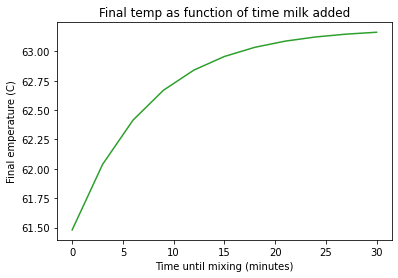

In [8]:
sweep.plot(label='mixture', color='C2',
           xlabel='Time until mixing (minutes)',
         ylabel='Final emperature (C)',
          title='Final temp as function of time milk added');

Note the values of the x-axis: this shows us final results as a function of `t_add`, not the temperature of the liquid over time.  

<br>

✅ Active reading: What is the optimal time to mix the two liquids?  What is the "metric" here?  Answer in a text box below this one.

<br>

---

## Validation and Interpretation: Comparing results to the analytic solution

### An analytic solution to the coffee problem

Remember that we started with an expression of Newton's law of cooling as a differential equation, and then we discretized that equation to incorporate it into a change function.   But can we just solve it analytically?  

<br>

Here's the differential equation:

<br>

$$\frac{dT}{dt} = -r (T - T_{env})$$ 

<br>

If we multiply the right side out, we can put it in this form:

<br>

$$\frac{dT}{dt} = -rT + rT_{env}$$

<br>

Remembering that $r$ and $T_{env}$ are both constants, we can write:

<br>

$$\frac{dT}{dt} = -rT + C$$

<br>

This equation tells us that he slope of the function $T = f(t)$ will vary with temperature.  Ignore the constant $C$ for a moment, and let's say we start with a positive temperature: the initial slope will be downward because $r$ is negative.  At the next step, $T$ will be smaller but still positive, so the slope will be more shallow but still downward.  As $T$ gets smaller and smaller, the slope will flatten out.  The opposite will happen if we start with a negative number: the slope will initially be large and positive but will gradually become small and positive.

<br>

The constant $C$, it turns out, just shifts all of the solutions up or down.  Here is a image of 9 possible particular solutions, each with a different initial temperature:

<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/Coffee_possible_solutions.PNG width = 600>







So we can see that each of these lines matches the description of our equation: the slope is proportional to the distance of the temperature from $T_{env} = 22 °C$.  We might also notice that the form of this diffential equation is very similar to our exponential equation for population:

<br>

$$\frac{dx}{dt} = -\alpha x$$

<br>

It's reasonable to assume, then, that the solution to the law of cooling is also exponential, and this turns out to be true.  The general solution is:

<br>

$$T{\left (t \right )} = C e^{-r t} + T_{env}$$ 

<br>

and the particular solution where $T(0) = T_{init}$ is:

<br>

$$T{\left (t \right )} =T_{env} + \left(T_{init}- T_{env}\right) e^{-r t}$$ 

<br>

✅ Active Reading: Describe in a text cell below this one what the image "Possible Particular Solutions" shows us about the physical system (i.e. coffee sitting in an environment).  What does each of these lines represent?

### An analytic solution to $r$

We now have an analytic equation that gives us the temperature at any time $t$ as long as we know the initial temperaturem the temperature at the environment, and the total heat transfer coefficient $r$. 

<br>

But $r$ is a complex constant that incorporates conduction, convection, and even radiation: we really have no way of determining it analytically.  But if we know the temperature at a time later than $t = 0$, we can solve the above equation for $r$! For instance, the temperature at $T(t_{end}) = T_{final}$.

<br>

Let's plug these values into the particular solution:

$$T_{final}  =T_{env} + \left(T_{init}- T_{env}\right) e^{-r t_{end}}$$ 

And then we can solve for $r$:

$$r = \frac{-1}{t_{end}} \ln{\left (\frac{T_{final} - T_{env}}{T_{init} - T_{env}} \right )}$$

where $ln$ is the natural log. 

<br>

So let's calculate $r$ using our analytic equation. The following function takes a `System` object and computes `r`:

In [9]:
from numpy import log

def compute_r(system):
    t_end = system['t_end']
    T_init = system['T_init']
    T_final = system['T_final']
    T_env = system['T_env']
    
    r = -(log((T_final - T_env) / (T_init - T_env)) / t_end)
    return r

We can use this function to compute `r` for the coffee, given the parameters of the problem.

In [10]:
coffee2 = make_system(90, 300, 0, 30,22)
coffee2['T_final'] = 70
r_coffee2 = compute_r(coffee2)
r_coffee2

0.011610223142273857

This value is close to the value of `r` we computed in the previous chapter, `0.115`, but not exactly the same.
That's because the simulations use discrete time steps, and the analysis uses continuous time.  Nevertheless, the results of the analysis are consistent with the simulation.
To check, we'll use the following function, which takes a system object and uses the analytic result to compute a time series:

In [11]:
from numpy import exp

def run_analysis(system):
    T_env, T_init, r = system['T_env'], system['T_init'], system['r']
    
    t_array = np.arange(system['t_0'], system['t_end']+1, system['dt']) 
       
    T_array = T_env + (T_init - T_env) * exp(-r * t_array)
    
    system['T_final'] = T_array[-1]
    return pd.Series(data=T_array, index=t_array)

The first line unpacks the system variables.
The next two lines compute `t_array`, which is a NumPy array of time stamps, and `T_array`, which is an array of the corresponding temperatures.
The last two lines store the final temperature in the system object and use `make_series` to return the results in a Pandas `Series`.

<br>

We can run it like this:

The final temperature of the coffee is 70.0 degrees.


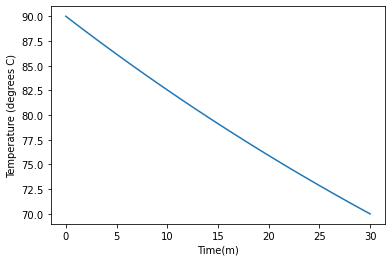

In [12]:
coffee2['r'] = r_coffee2
results2 = run_analysis(coffee2)
results2.plot(xlabel='Time(m)',ylabel='Temperature (degrees C)');
print("The final temperature of the coffee is", coffee2['T_final'], "degrees.")

The final temperature is 70 °C, as it should be. In fact, the results
are identical to what we got by simulation, with a small difference due to rounding.

In [13]:
coffee['r'] = 0.011543
results = run_simulation(coffee, change_func)

In [14]:
diff =np.abs(results-results2)
np.mean(diff)

6.917310602670656e-05

Since we can solve this problem analytically, you might wonder why we bothered writing a simulation. 
One reason is validation: since we solved the same problem two ways, we can be more confident that the answer is correct. 
The other reason is flexibility: now that we have a working simulation, it would be easy to add more features. For example, the temperature of the environment might change over time, or we could simulate the coffee and container as two objects. 
If the coffee and milk are next to each other, we could include the heat flow between them. A model with these features would be difficult or impossible to solve analytically. 

✅ Active reading:  Add properly formatted documentation to the function `run_analysis`, including a docstring and line comments for each line of the function.

<br>

---

## Summary

In this notebook, we finished the coffee cooling problem from the previous chapter, and found that it is better to add the milk at the end.  Then we explored the analytical solution to the problem.

<br>

As an exercise you will have a chance to explore a variation of the problem where the answer might be different.

<br>

---

## Exercises


### Exercise 1

Use `compute_r` to compute `r_milk` according to the analytic solution.  Run the analysis with this value of `r_milk` and confirm that the results are consistent with the simulation.

In [15]:
# Find value for r_milk analytically using the compute_r function
# You will need to add a value for T_final to the system you create


In [16]:
# Run an analysis to using run_analysis with the 'r' value you found above
# Plot the results and confirm results give the expected results


### Exercise 2

✅  Does the analytic value of `r` you found in exercise 1 match the value you found computationally in the previous notebook for milk?  What should the value of `T_final` be if the analytic model with this value of `r` is to be validated? Explain your answers in full sentences.

✅ ✅  Answer exercise 2 here.